In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def merge_data(cornwall_df, lsd_df, on='Date', period='Daily'):
    Merge_df = pd.merge(cornwall_df, lsd_df, on=on, suffixes=('_Cornwall', '_LSD'))
    Merge_df = Merge_df.rename(columns={"Discharge (cubic meters per second) - Débit (mètres cubes par seconde)": "Discharge (cubic meters per second) - Débit (mètres cubes par seconde), Q"})
    Merge_df['hydraulic_head_cornwall'] = 72.5 + Merge_df["Water Level (meters) - Niveau d'eau (mètres)_LSD"] 
    Merge_df['hydraulic_head_LSD'] = 46.4 + Merge_df["Water Level (meters) - Niveau d'eau (mètres)_LSD"]  # Assuming 76.0 meters is the tailwater level for Long Sault Dam

    Merge_df['hydraulic_head, h'] =  abs(Merge_df['hydraulic_head_LSD'] - Merge_df['hydraulic_head_cornwall'])
    Merge_df['overflow'] = np.maximum(Merge_df['hydraulic_head, h'] - 25,0)  # Assuming overflow occurs when head exceeds 25 meters
    # x * Q * g * p * h
    Merge_df["Power (Watts)"] = Merge_df["Discharge (cubic meters per second) - Débit (mètres cubes par seconde), Q"] * 9.81 * 998 * Merge_df['hydraulic_head, h']
    Merge_df[f"hour, {period}"] = (Merge_df.index+1) * 24 if period == 'Daily' else Merge_df.index + 1  # Assuming each row represents one hour or one day
    Merge_df["seconds"] = Merge_df[f"hour, {period}"] * 3600
    Merge_df["Energy (Joules)"] = Merge_df["Power (Watts)"] * Merge_df["seconds"]

    return Merge_df

In [3]:
cornwall_hourly = pd.read_csv("./clean/cornwall_hourly_data.csv")
lsd = pd.read_csv("./clean/LSD_final_data.csv")
Merge_df = merge_data(cornwall_hourly, lsd, on='DateTime', period='Hourly')
Merge_df




,Station Name_Cornwall,Station Code_Cornwall,Date_Cornwall,Time_Cornwall,DateTime,Water Level (meters) - Niveau d'eau (mètres)_Cornwall,"Discharge (cubic meters per second) - Débit (mètres cubes par seconde), Q",Station Name_LSD,Station Code_LSD,Date_LSD,Time_LSD,Water Level (meters) - Niveau d'eau (mètres)_LSD,hydraulic_head_cornwall,hydraulic_head_LSD,"hydraulic_head, h",overflow,Power (Watts),"hour, Hourly",seconds,Energy (Joules)
0,Cornwall,14870,2024-01-01,00:00,2024-01-01 00:00:00,0.410,261000.0,Long Sault Dam,14805,2024-01-01,00:00,0.38,72.88,46.78,26.1,1.1,6.669305e+10,1,3600,2.400950e+14
1,Cornwall,14870,2024-01-01,01:00,2024-01-01 01:00:00,0.412,261000.0,Long Sault Dam,14805,2024-01-01,01:00,0.38,72.88,46.78,26.1,1.1,6.669305e+10,2,7200,4.801899e+14
2,Cornwall,14870,2024-01-01,02:00,2024-01-01 02:00:00,0.411,261000.0,Long Sault Dam,14805,2024-01-01,02:00,0.37,72.87,46.77,26.1,1.1,6.669305e+10,3,10800,7.202849e+14
3,Cornwall,14870,2024-01-01,03:00,2024-01-01 03:00:00,0.414,261000.0,Long Sault Dam,14805,2024-01-01,03:00,0.37,72.87,46.77,26.1,1.1,6.669305e+10,4,14400,9.603799e+14
4,Cornwall,14870,2024-01-01,04:00,2024-01-01 04:00:00,0.416,261000.0,Long Sault Dam,14805,2024-01-01,04:00,0.37,72.87,46.77,26.1,1.1,6.669305e+10,5,18000,1.200475e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,Cornwall,14870,2024-12-31,19:00,2024-12-31 19:00:00,0.485,239000.0,Long Sault Dam,14805,2024-12-31,19:00,0.56,73.06,46.96,26.1,1.1,6.107141e+10,8757,31525200,1.925288e+18
8757,Cornwall,14870,2024-12-31,20:00,2024-12-31 20:00:00,0.494,239000.0,Long Sault Dam,14805,2024-12-31,20:00,0.55,73.05,46.95,26.1,1.1,6.107141e+10,8758,31528800,1.925508e+18
8758,Cornwall,14870,2024-12-31,21:00,2024-12-31 21:00:00,0.518,239000.0,Long Sault Dam,14805,2024-12-31,21:00,0.56,73.06,46.96,26.1,1.1,6.107141e+10,8759,31532400,1.925728e+18
8759,Cornwall,14870,2024-12-31,22:00,2024-12-31 22:00:00,0.527,239000.0,Long Sault Dam,14805,2024-12-31,22:00,0.58,73.08,46.98,26.1,1.1,6.107141e+10,8760,31536000,1.925948e+18


In [4]:
Merge_df.to_csv("./Merged_hourly_data.csv", index=False)

## Part A

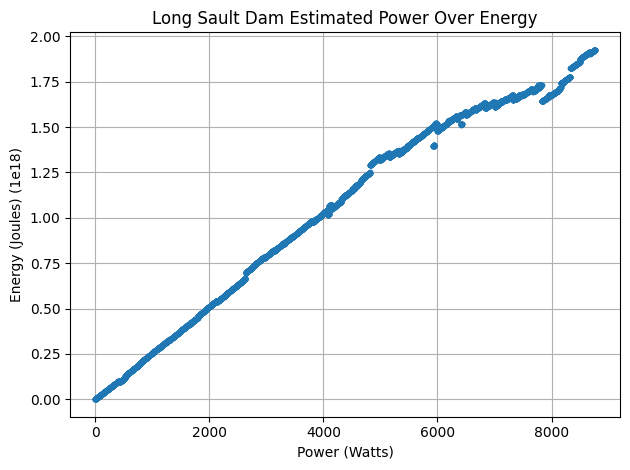

In [10]:
Merge_sorted = Merge_df.sort_values(by='DateTime', ascending=True)

# Plot Power vs Energy with clear axis labels and move scientific offset into ylabel

import pandas as _pd  # local alias to avoid shadowing in notebook

# Ensure numeric types in case they were read as strings (convert before plotting)

for c in ['Power (Watts)', 'Energy (Joules)']:
    if c in Merge_df.columns:
        Merge_df[c] = _pd.to_numeric(Merge_df[c], errors='coerce')

ax = Merge_df.plot(x='Power (Watts)', y='Energy (Joules)',
                   title='Long Sault Dam Estimated Power Over Energy',
                   use_index=False, legend=False, style='o', markersize=3)

# Force a draw so matplotlib computes offset text and tick formatting
plt.draw()

# Explicitly set x and base y labels
ax.set_xlabel('Power (Watts)')
base_ylabel = 'Energy (Joules)'

# Capture any scientific offset generated by the formatter
try:
    # Get the text shown as offset (may be empty)
    raw_offset = ax.yaxis.get_offset_text().get_text()
except Exception:
    raw_offset = ''

# Disable use of offset in the formatter so it doesn't show above the axis
try:
    formatter = ax.yaxis.get_major_formatter()
    # Many formatters (ScalarFormatter) have set_useOffset
    if hasattr(formatter, 'set_useOffset'):
        formatter.set_useOffset(False)
except Exception:
    pass

# If there was a non-empty offset, move it into the ylabel and hide the offset text
offset_text = raw_offset.strip() if isinstance(raw_offset, str) else ''
if offset_text:
    ax.set_ylabel(f"{base_ylabel} ({offset_text})")
    try:
        ax.yaxis.get_offset_text().set_visible(False)
    except Exception:
        # Some backends may expose offset text differently; ignore if we can't hide it
        pass
else:
    ax.set_ylabel(base_ylabel)

ax.grid(True)
plt.tight_layout()

## Part B

Columns:
['Station Name_Cornwall', 'Station Code_Cornwall', 'Date_Cornwall', 'Time_Cornwall', 'DateTime', "Water Level (meters) - Niveau d'eau (mètres)_Cornwall", 'Discharge (cubic meters per second) - Débit (mètres cubes par seconde), Q', 'Station Name_LSD', 'Station Code_LSD', 'Date_LSD', 'Time_LSD', "Water Level (meters) - Niveau d'eau (mètres)_LSD", 'hydraulic_head_cornwall', 'hydraulic_head_LSD', 'hydraulic_head, h', 'overflow', 'Power (Watts)', 'hour, Hourly', 'seconds', 'Energy (Joules)']

Using column for inspection: overflow

Dtype after coercion: float64

Basic statistics:
count    8.761000e+03
mean     1.100000e+00
std      4.932826e-15
min      1.100000e+00
25%      1.100000e+00
50%      1.100000e+00
75%      1.100000e+00
max      1.100000e+00
Name: overflow, dtype: float64

Rows with overflow <= 0: 0

Rows above 99th percentile (count 0):

Rounded value counts (to 6 decimals) for the column:
overflow
1.1    8761
Name: count, dtype: int64


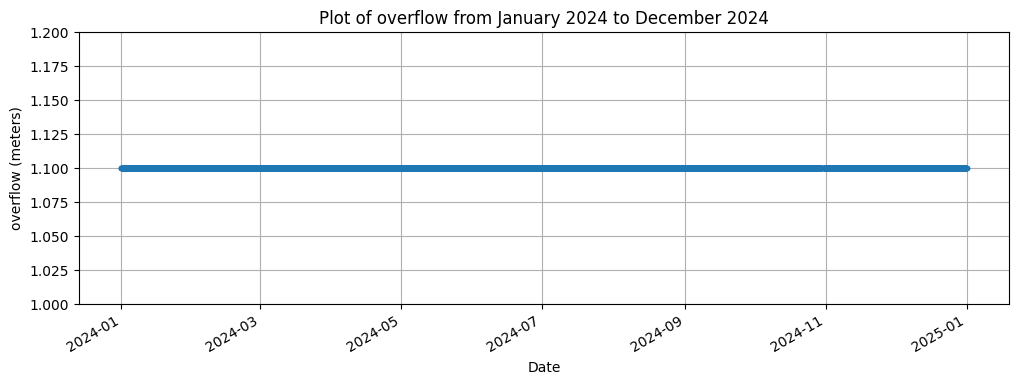

In [16]:
# Diagnostic and robust plotting for 'overflow' (and discharge) values
# This cell inspects dtypes/values and plots the 'overflow' column with
# quantile-based y-limits so small values (e.g. ~1.1) are visible even
# when there are extreme outliers that would otherwise squash the axis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the merged CSV (adjust path if your file is elsewhere)
fn = './clean/Merged_hourly_data.csv'
df = pd.read_csv(fn)

print('Columns:')
print(df.columns.tolist())

# Choose the column to inspect/plot. Change if your column has a different name.
col_candidates = [c for c in df.columns if 'overflow' in c.lower()]
if col_candidates:
    col = col_candidates[0]
else:
    # fallback: use column name exactly 'overflow' if present
    col = 'overflow' if 'overflow' in df.columns else None

print('\nUsing column for inspection:', col)
if col is None:
    raise ValueError('No column named or containing "overflow" found in the CSV.\n' 
                     'Check df.columns and update the `col` variable in this cell to the correct name.')

# Coerce to numeric (float64) to avoid integer overflow and detect bad parsing
df[col] = pd.to_numeric(df[col], errors='coerce')

# Quick diagnostics
print('\nDtype after coercion:', df[col].dtype)
print('\nBasic statistics:')
print(df[col].describe())

# Show any non-positive (<=0) values which you said shouldn't exist
neg_or_zero = df[df[col] <= 0]
print(f"\nRows with {col} <= 0: {len(neg_or_zero)}")
if len(neg_or_zero) > 0:
    display(neg_or_zero.head(10))

# Show extreme values that might be causing axis compression
abs_large = df[np.abs(df[col]) > df[col].quantile(0.99)]
print(f"\nRows above 99th percentile (count {len(abs_large)}):")
if len(abs_large) > 0:
    display(abs_large.head(10))

# If you expect values close to 1.1, check the rounded value counts
print('\nRounded value counts (to 6 decimals) for the column:')
print(df[col].round(6).value_counts().head(20))

# Build a datetime index for plotting if DateTime column exists
if 'DateTime' in df.columns:
    try:
        times = pd.to_datetime(df['DateTime'])
    except Exception:
        times = None
        print('Could not parse DateTime column to datetimes; plotting will use integer index')
else:
    times = None
    print('No `DateTime` column found; plotting will use integer index')

# Plot with quantile-based limits so small values are visible
q_low, q_high = df[col].quantile([0.01, 0.99]).tolist()
pad = max(0.1, 0.02 * (q_high - q_low if q_high > q_low else abs(q_high) + 0.1))

plt.figure(figsize=(12,4))
if times is not None:
    plt.plot(times, df[col], marker='o', ls='-', ms=3)
    plt.gcf().autofmt_xdate()
else:
    plt.plot(df[col].values, marker='o', ls='-', ms=3)

# If the 99th percentile is much larger than the 1st, limit axis to show central values
if q_high > q_low and (q_high - q_low) > 0:
    plt.ylim(q_low - pad, q_high + pad)
else:
    # fallback small fixed range around expected value 1.1
    plt.ylim(0, 2)

plt.title(f"Plot of {col} from January 2024 to December 2024")
plt.grid(True)
plt.xlabel('Date' if times is not None else 'Index')
plt.ylabel(f"{col} (meters)")
plt.show()
